In [1]:
import pandas as pd
import tensorflow as tf
import rdkit
from main import create_input, create_model, predict
from argparse import ArgumentParser
from molgraph import single_mol_from_supergraph
import numpy as np

Using backend: tensorflow


# Run predictive model

In [2]:
parser = ArgumentParser()
parser.add_argument('-predict', action="store_true", default=True)
parser.add_argument('-watsoneq', action='store_true', default=False)
parser.add_argument('-K_fold', action='store_true', default=False)
parser.add_argument('-maxatoms', type=int, default=64)
parser.add_argument('-lr', type=float, default=5.0e-4)
parser.add_argument('-epoch', type=int, default=100)
parser.add_argument('-batchsize', type=int, default=256)
parser.add_argument('-layers', type=int, default=5)
parser.add_argument('-heads', type=int, default=5)
parser.add_argument('-residcon', action="store_true", default=True)
parser.add_argument('-explicitH', action="store_true", default=False)
parser.add_argument('-dropout', type=float, default=0.0)
parser.add_argument('-modelname', type=str, default='best_211007')
parser.add_argument('-num_hidden', type=int, default=32)
parser.add_argument('-train_only', action="store_true", default=False)
parser.add_argument('-sw_thr', type=float, default=0.0)
parser.add_argument('-sw_decay', type=int, default=1)
parser.add_argument('-loss', type=str, default='kl_div_normal')
args = parser.parse_args('')

In [3]:
df = pd.read_csv('data/Data_211005.csv')
tmp = []
#for smi in df.smiles.unique():
#    tmp.append([smi,298.15])
#pd.DataFrame(tmp).to_csv('molecules_to_predict.csv', header=['smiles','temperature'], index=False)
pd.DataFrame(df[['smiles','Train/Valid/Test','temperature','HoV (kJ/mol)']]).to_csv('molecules_to_predict.csv', index=False)

In [4]:
device ='/cpu:0'
data = pd.read_csv('molecules_to_predict.csv')
data['total_atoms'] = [ rdkit.Chem.MolFromSmiles(smi).GetNumHeavyAtoms() for smi in data.smiles]
INPUT = create_input(data, device, args)
data, num_mols, T, Graphs, seg = INPUT
atom_feat_dim = Graphs.ndata['feat'].shape[-1]
model, model_name = create_model(args, atom_feat_dim, '')
################
Predicted_HoV, atom_features_each_layer, Attention_each_layer, before_T_update, after_T_update = predict(model, \
                                                                                  Graphs.ndata['feat'], Graphs, \
                                                         seg, args.maxatoms, T, '', num_mols, mu_s_NLR=[])
if len(Predicted_HoV.shape) == 2: # mean+std learning
    pred_mean, pred_stddev = Predicted_HoV[:, 0], Predicted_HoV[:, 1]
    data['Predicted'] = pred_mean.numpy()
    data['ML_unc'] = pred_stddev.numpy()
else:
    data['Predicted'] = Predicted_HoV.numpy()

0
1
2
3
4


In [5]:
#Just to test if the model was loaded properly
valid = data[data['Train/Valid/Test'] == 'Valid']
np.abs(valid.Predicted - valid['HoV (kJ/mol)']).mean()

4.213752654098938

In [6]:
data

,smiles,Train/Valid/Test,temperature,HoV (kJ/mol),total_atoms,Predicted,ML_unc
137734,C,Test,150.0000,6.61901,1,87.557961,22.069706
137736,C,Test,90.6941,8.73150,1,90.610909,23.045452
137735,C,Test,100.0000,8.51043,1,89.892754,22.790493
137737,C#C,Test,308.3950,0.01000,2,10.274034,6.190171
137738,C#C,Test,191.6600,16.11890,2,15.257702,4.088116
...,...,...,...,...,...,...,...
124098,c1coc(Cc2ccco2)c1,Train,440.0000,42.35520,11,42.299168,2.965742
124099,c1coc(Cc2ccco2)c1,Train,300.0000,52.88470,11,51.890205,5.720402
124078,c1coc(Cc2ccco2)c1,Train,480.0000,38.85640,11,38.877991,2.603239
124091,c1coc(Cc2ccco2)c1,Train,400.0000,45.58840,11,45.296219,3.306897


In [7]:
before_T_update = before_T_update.numpy()
after_T_update = after_T_update.numpy()

In [8]:
from tqdm import tqdm
norms = []
for i in tqdm(range(len(before_T_update))):
    norms.append( np.linalg.norm(before_T_update[i] - after_T_update[i], 2) )

100%|██████████| 153105/153105 [00:07<00:00, 20620.61it/s]


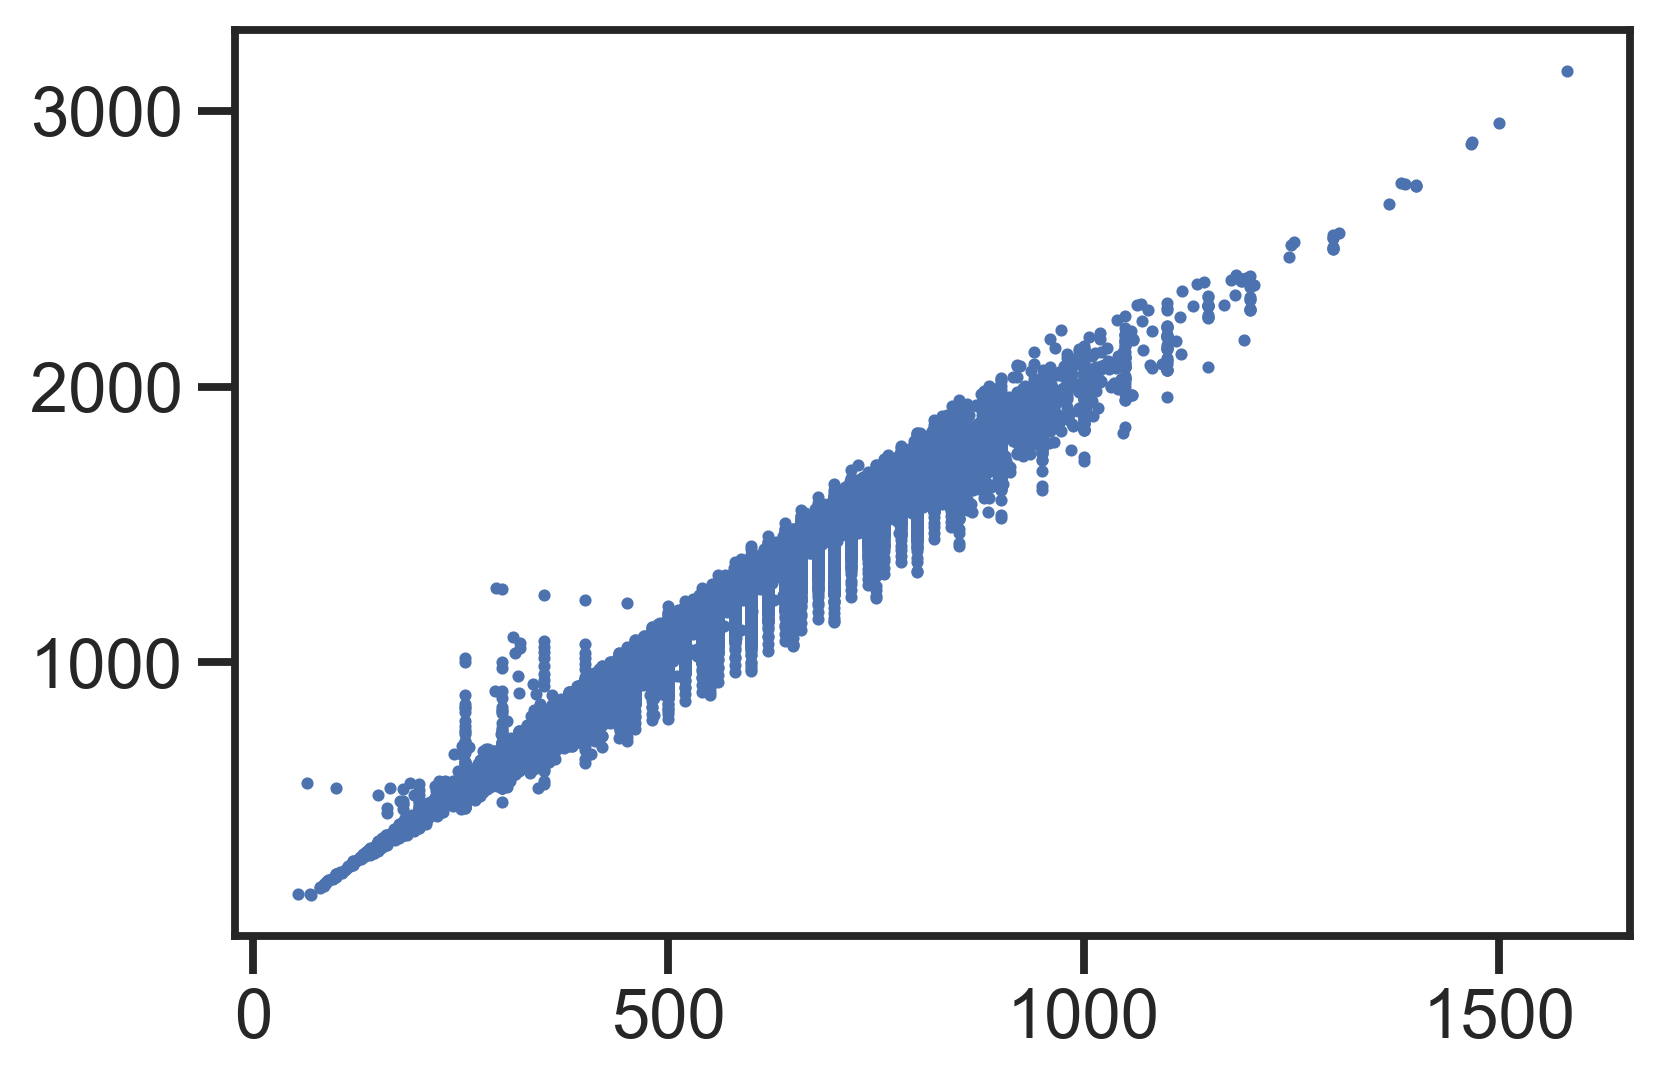

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 24})

plt.scatter(data['temperature'], norms, s=2)

In [10]:
np.corrcoef(data['temperature'], norms)[0][1]

0.9900646865907132

In [11]:
import copy
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from IPython.display import display, Image
import matplotlib
import matplotlib.cm as cm
from rdkit import Chem

def drawmol(smiles, atom_attention_scores):
    # need to replace atom_weights, bg.number_of_nodes
    
    norm = matplotlib.colors.Normalize(vmin=35, vmax=89)
    cmap = cm.get_cmap('Greens')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_attention_scores[i]) for i in range(len(atom_attention_scores))}

    mol = Chem.MolFromSmiles(smiles)   
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(600, 600)
    drawer.SetFontSize(30)
    
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, highlightAtoms=range(len(atom_attention_scores)),
                             highlightBonds=[],
                             highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    return svg

In [12]:
#smiles_of_interest = 'CCCC(O)CC(=O)OCC'
smiles_of_interest = 'CCCCCC(=O)OCC'
row_indices = [i for i, x in enumerate(list(data.smiles)) if x == smiles_of_interest]


In [13]:
diffs_by_atom_each_T = {}
for i in row_indices: # i: each temperature
    T = list(data.temperature)[i]
    atomfeat_before, atomfeat_after = before_T_update[i], after_T_update[i]
    
    diffs_by_atom = []
    for j in range(Chem.MolFromSmiles(smiles_of_interest).GetNumHeavyAtoms()): # per each atom
        diffs_by_atom.append(np.linalg.norm(atomfeat_before[j] - atomfeat_after[j], 2))   
    diffs_by_atom_each_T[T] = diffs_by_atom
    

400.0


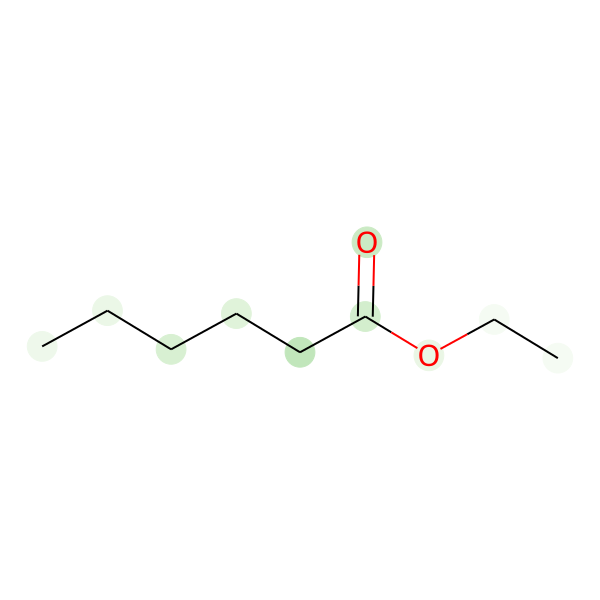

600.0


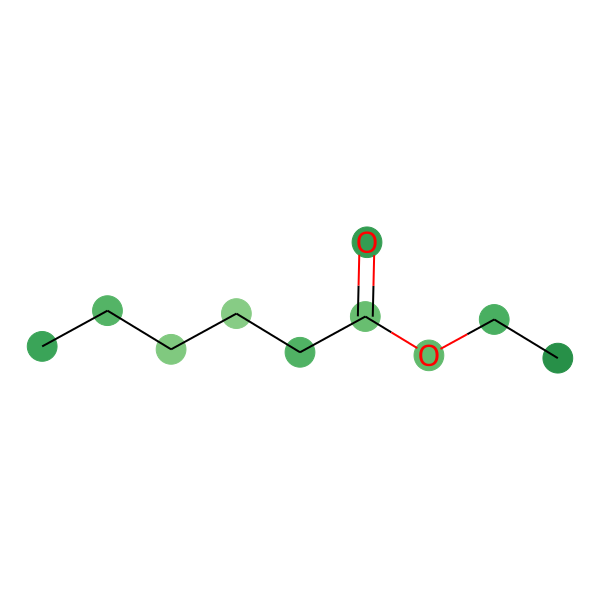

In [14]:
for T in sorted(diffs_by_atom_each_T.keys()):
    #print(T, min(diffs_by_atom_each_T[T]), max(diffs_by_atom_each_T[T]))
    if T == 400.0 or T == 600.0:
        print(T)
        display(SVG(drawmol(smiles_of_interest, diffs_by_atom_each_T[T])))
        #print(T, diffs_by_atom_each_T[T])